In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(project_root)

from models import AttentionVNet, VNet
from lit_models import LitBaseVNet
from dataloader import ProstateDataModule, download_and_extract_msd_prostate

torch.set_float32_matmul_precision('medium')


In [4]:
import gc

def run_grid_search():
    lrs = [1e-3, 1e-4, 1e-5]
    batch_sizes = [2, 4]
    base_channels_list = [16, 32] 
    
    best_score = -float('inf')
    best_params = None
    best_model_path = None

    DATA_ROOT = "../data"

    SAVE_DIR = "grid_search_results"
    os.makedirs(SAVE_DIR, exist_ok=True)

    for lr in lrs:
        for bs in batch_sizes:
            for bc in base_channels_list:
                print(f"\n Testing: lr={lr}, batch_size={bs}, base_channels={bc}")
                
                dm = ProstateDataModule(
                    root_dir=DATA_ROOT, 
                    batch_size=bs,
                    roi_size=(128, 128, 64),
                    num_workers=4,
                    cache_dataset=True
                )

                model_inner = AttentionVNet(in_ch=2, out_ch=3, base_channels=bc) 
                model = LitBaseVNet(model_obj=model_inner, in_ch=2, out_ch=3, lr=lr)

                logger = TensorBoardLogger("grid_search_logs", name=f"lr{lr}_bs{bs}_bc{bc}")

                trainer = pl.Trainer(
                    max_epochs=10,
                    accelerator="auto",
                    devices=1,
                    logger=logger,
                    callbacks=[EarlyStopping(monitor="val_dice", mode="max", patience=4)],
                    enable_progress_bar=True
                )

                trainer.fit(model, datamodule=dm)

                val_dice = trainer.callback_metrics.get("val_dice", 0).item()
                
                print(f"Results val Dice = {val_dice:.4f}")

                if val_dice > best_score:
                    best_score = val_dice
                    best_params = {'lr': lr, 'batch_size': bs, 'base_channels': bc}
                    filename = f"best_model_lr{lr}_bs{bs}_bc{bc}.ckpt"
                    best_model_path = os.path.join(SAVE_DIR, filename)
                    trainer.save_checkpoint(best_model_path)
                
                del model
                del trainer
                del dm
                gc.collect()
                torch.cuda.empty_cache()

    print("\n")
    print(f"Best params: {best_params}")
    print(f"Best val dice: {best_score:.4f}")
    return best_params, best_model_path

best_params, best_path = run_grid_search()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.



 Testing: lr=0.001, batch_size=2, base_channels=16


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 26.72it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 2.9 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.774    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=0, val_loss=0.750, val_dice=0.157, val_miou=0.390, train_loss=0.682] 
Results val Dice = 0.1574


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=0.001, batch_size=2, base_channels=32


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 27.07it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 11.8 M | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.063    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 13/13 [00:13<00:00,  0.94it/s, v_num=0, val_loss=0.663, val_dice=0.0751, val_miou=0.357, train_loss=0.463]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:14<00:00,  0.91it/s, v_num=0, val_loss=0.663, val_dice=0.0751, val_miou=0.357, train_loss=0.463]
Results val Dice = 0.0751


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=0.001, batch_size=4, base_channels=16


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 26.38it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 2.9 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.774    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s, v_num=0, val_loss=0.678, val_dice=0.172, val_miou=0.398, train_loss=0.597]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s, v_num=0, val_loss=0.678, val_dice=0.172, val_miou=0.398, train_loss=0.597]
Results val Dice = 0.1719


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=0.001, batch_size=4, base_channels=32


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 29.65it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 11.8 M | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.063    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 7/7 [02:18<00:00,  0.05it/s, v_num=0, val_loss=0.662, val_dice=0.172, val_miou=0.395, train_loss=0.515]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 7/7 [02:18<00:00,  0.05it/s, v_num=0, val_loss=0.662, val_dice=0.172, val_miou=0.395, train_loss=0.515]
Results val Dice = 0.1719


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=0.0001, batch_size=2, base_channels=16


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 27.89it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 2.9 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.774    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=0, val_loss=1.220, val_dice=0.220, val_miou=0.430, train_loss=1.240]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, v_num=0, val_loss=1.220, val_dice=0.220, val_miou=0.430, train_loss=1.240]
Results val Dice = 0.2200


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=0.0001, batch_size=2, base_channels=32


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 28.82it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 11.8 M | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.063    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 13/13 [00:14<00:00,  0.90it/s, v_num=0, val_loss=0.961, val_dice=0.0168, val_miou=0.335, train_loss=0.931]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:14<00:00,  0.88it/s, v_num=0, val_loss=0.961, val_dice=0.0168, val_miou=0.335, train_loss=0.931]
Results val Dice = 0.0168


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=0.0001, batch_size=4, base_channels=16


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 28.66it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 2.9 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.774    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s, v_num=0, val_loss=1.500, val_dice=0.0714, val_miou=0.327, train_loss=1.470]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s, v_num=0, val_loss=1.500, val_dice=0.0714, val_miou=0.327, train_loss=1.470]
Results val Dice = 0.0714


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=0.0001, batch_size=4, base_channels=32


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 24.32it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 11.8 M | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.063    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 7/7 [02:18<00:00,  0.05it/s, v_num=0, val_loss=1.200, val_dice=0.0117, val_miou=0.333, train_loss=1.200]  


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Results val Dice = 0.0117

 Testing: lr=1e-05, batch_size=2, base_channels=16


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 25.40it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 2.9 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.774    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=0, val_loss=1.720, val_dice=0.069, val_miou=0.226, train_loss=1.720]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, v_num=0, val_loss=1.720, val_dice=0.069, val_miou=0.226, train_loss=1.720]
Results val Dice = 0.0690


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=1e-05, batch_size=2, base_channels=32


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 27.41it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 11.8 M | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.063    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 13/13 [00:14<00:00,  0.91it/s, v_num=0, val_loss=1.540, val_dice=0.145, val_miou=0.377, train_loss=1.560]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:14<00:00,  0.89it/s, v_num=0, val_loss=1.540, val_dice=0.145, val_miou=0.377, train_loss=1.560]
Results val Dice = 0.1454


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



 Testing: lr=1e-05, batch_size=4, base_channels=16


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 26.46it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 2.9 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.774    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s, v_num=0, val_loss=1.880, val_dice=0.0174, val_miou=0.134, train_loss=1.920]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s, v_num=0, val_loss=1.880, val_dice=0.0174, val_miou=0.134, train_loss=1.920]
Results val Dice = 0.0174

 Testing: lr=1e-05, batch_size=4, base_channels=32


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 27.84it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 11.8 M | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.063    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 7/7 [02:21<00:00,  0.05it/s, v_num=0, val_loss=1.650, val_dice=0.0467, val_miou=0.311, train_loss=1.650]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 7/7 [02:21<00:00,  0.05it/s, v_num=0, val_loss=1.650, val_dice=0.0467, val_miou=0.311, train_loss=1.650]
Results val Dice = 0.0467


Best params: {'lr': 0.0001, 'batch_size': 2, 'base_channels': 16}
Best val dice: 0.2200


In [2]:
DATA_ROOT = "../data"
download_and_extract_msd_prostate(DATA_ROOT)

dm = ProstateDataModule(
    root_dir=DATA_ROOT, 
    batch_size=2,
    roi_size=(128, 128, 64),
    num_workers=4,
    cache_dataset=True
)

model_inner = AttentionVNet(in_ch=2, out_ch=3, base_channels=24) 
model = LitBaseVNet(model_obj=model_inner, in_ch=2, out_ch=3, lr=1e-4)

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
Loading dataset: 100%|██████████| 16/16 [00:01<00:00, 13.47it/s]


Kształt obrazu: torch.Size([2, 128, 128, 64])
Kształt maski: torch.Size([1, 128, 128, 64])
Unikalne wartości w masce: tensor([0., 1., 2.])


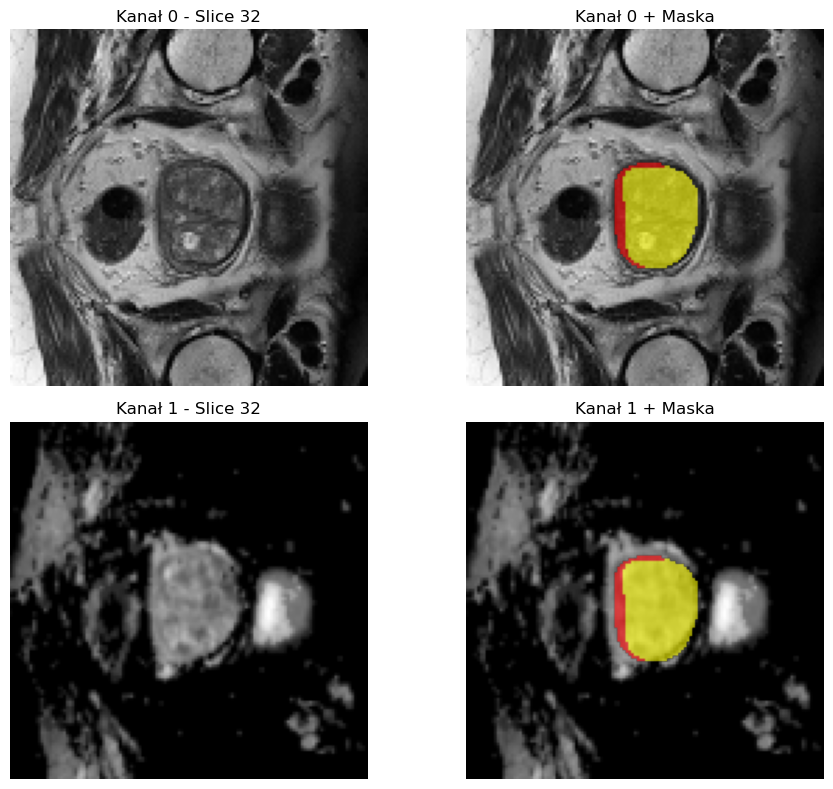

In [3]:

import numpy as np

def check_dataloader(data_module):
    data_module.setup()
    train_loader = data_module.train_dataloader()
    batch = next(iter(train_loader))
    
    if isinstance(batch, list):
        batch_data = batch[0]
    else:
        batch_data = batch

    images = batch_data['image'] 
    labels = batch_data['label']
    
    img = images[0]
    lab = labels[0]
    
    print(f"Kształt obrazu: {img.shape}")
    print(f"Kształt maski: {lab.shape}")
    print(f"Unikalne wartości w masce: {torch.unique(lab)}")

    slice_idx = img.shape[-1] // 2 
    n_channels = img.shape[0]

    fig, axes = plt.subplots(n_channels, 2, figsize=(10, 4 * n_channels))
    if n_channels == 1: axes = np.expand_dims(axes, axis=0)

    for c in range(n_channels):
        img_2d = img[c, :, :, slice_idx].detach().cpu().numpy()
        lab_2d = lab[0, :, :, slice_idx].detach().cpu().numpy()
        
        axes[c, 0].imshow(img_2d, cmap='gray')
        axes[c, 0].set_title(f"Kanał {c} - Slice {slice_idx}")
        axes[c, 0].axis('off')
        
        axes[c, 1].imshow(img_2d, cmap='gray')
        masked = np.ma.masked_where(lab_2d == 0, lab_2d)
        axes[c, 1].imshow(masked, cmap='autumn', alpha=0.6)
        axes[c, 1].set_title(f"Kanał {c} + Maska")
        axes[c, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

check_dataloader(dm)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_dice",
    dirpath="../checkpoints/",
    filename="best-attention-vnet-{epoch:02d}-{val_dice:.3f}",
    save_top_k=1,
    mode="max",
)

checkpoint_callback_last = ModelCheckpoint(
    dirpath="../checkpoints/",
    filename="last-model",
    save_top_k=1,
    every_n_epochs=1,
    save_on_train_epoch_end=True
)

early_stop_callback = EarlyStopping(
    monitor="val_dice",
    patience=250,
    mode="max",
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

logger = TensorBoardLogger("../tb_logs", name="AttentionVNet_Prostate")

trainer = pl.Trainer(
    max_epochs=600,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback, checkpoint_callback_last, lr_monitor],
    logger=logger,
    log_every_n_steps=10,
    accumulate_grad_batches=4
)

trainer.fit(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 27.37it/s]
Checkpoint directory /home/tim/medyczne/projekt/Prostate-MRI-Segmentation/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | AttentionVNet          | 6.6 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.479    Total estimated model params size (MB)
146       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=17, val_loss=2.980, val_dice=0.000669, train_loss=3.020]

Metric val_dice improved. New best score: 0.001


Epoch 1: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s, v_num=17, val_loss=2.970, val_dice=0.015, train_loss=2.960]   

Metric val_dice improved by 0.014 >= min_delta = 0.0. New best score: 0.015


Epoch 2: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=17, val_loss=2.940, val_dice=0.119, train_loss=2.910]

Metric val_dice improved by 0.104 >= min_delta = 0.0. New best score: 0.119


Epoch 4: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=17, val_loss=2.890, val_dice=0.136, train_loss=2.850] 

Metric val_dice improved by 0.017 >= min_delta = 0.0. New best score: 0.136


Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s, v_num=17, val_loss=2.810, val_dice=0.228, train_loss=2.770] 

Metric val_dice improved by 0.092 >= min_delta = 0.0. New best score: 0.228


Epoch 13: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s, v_num=17, val_loss=2.770, val_dice=0.274, train_loss=2.700] 

Metric val_dice improved by 0.046 >= min_delta = 0.0. New best score: 0.274


Epoch 18: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s, v_num=17, val_loss=2.700, val_dice=0.288, train_loss=2.650]

Metric val_dice improved by 0.015 >= min_delta = 0.0. New best score: 0.288


Epoch 25: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=17, val_loss=2.660, val_dice=0.356, train_loss=2.600] 

Metric val_dice improved by 0.068 >= min_delta = 0.0. New best score: 0.356


Epoch 50: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s, v_num=17, val_loss=2.620, val_dice=0.391, train_loss=2.520]

Metric val_dice improved by 0.035 >= min_delta = 0.0. New best score: 0.391


Epoch 63: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=17, val_loss=2.470, val_dice=0.452, train_loss=2.370] 

Metric val_dice improved by 0.061 >= min_delta = 0.0. New best score: 0.452


Epoch 77: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s, v_num=17, val_loss=2.330, val_dice=0.454, train_loss=2.160]

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.454


Epoch 83: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=17, val_loss=2.240, val_dice=0.466, train_loss=2.050]

Metric val_dice improved by 0.012 >= min_delta = 0.0. New best score: 0.466


Epoch 91: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s, v_num=17, val_loss=2.080, val_dice=0.475, train_loss=1.900]

Metric val_dice improved by 0.009 >= min_delta = 0.0. New best score: 0.475


Epoch 96: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s, v_num=17, val_loss=2.020, val_dice=0.497, train_loss=1.850]

Metric val_dice improved by 0.022 >= min_delta = 0.0. New best score: 0.497


Epoch 107: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=17, val_loss=1.870, val_dice=0.518, train_loss=1.660]

Metric val_dice improved by 0.021 >= min_delta = 0.0. New best score: 0.518


Epoch 110: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s, v_num=17, val_loss=1.840, val_dice=0.520, train_loss=1.640]

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.520


Epoch 120: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s, v_num=17, val_loss=1.800, val_dice=0.524, train_loss=1.530]

Metric val_dice improved by 0.005 >= min_delta = 0.0. New best score: 0.524


Epoch 170: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s, v_num=17, val_loss=1.420, val_dice=0.552, train_loss=1.170] 

Metric val_dice improved by 0.028 >= min_delta = 0.0. New best score: 0.552


Epoch 182: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, v_num=17, val_loss=1.300, val_dice=0.558, train_loss=0.957]

Metric val_dice improved by 0.005 >= min_delta = 0.0. New best score: 0.558


Epoch 194: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, v_num=17, val_loss=1.250, val_dice=0.567, train_loss=0.894]

Metric val_dice improved by 0.009 >= min_delta = 0.0. New best score: 0.567


Epoch 444: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s, v_num=17, val_loss=1.330, val_dice=0.511, train_loss=0.399]

Monitored metric val_dice did not improve in the last 250 records. Best score: 0.567. Signaling Trainer to stop.


Epoch 444: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, v_num=17, val_loss=1.330, val_dice=0.511, train_loss=0.399]


Loading dataset: 100%|██████████| 16/16 [00:01<00:00, 13.43it/s]


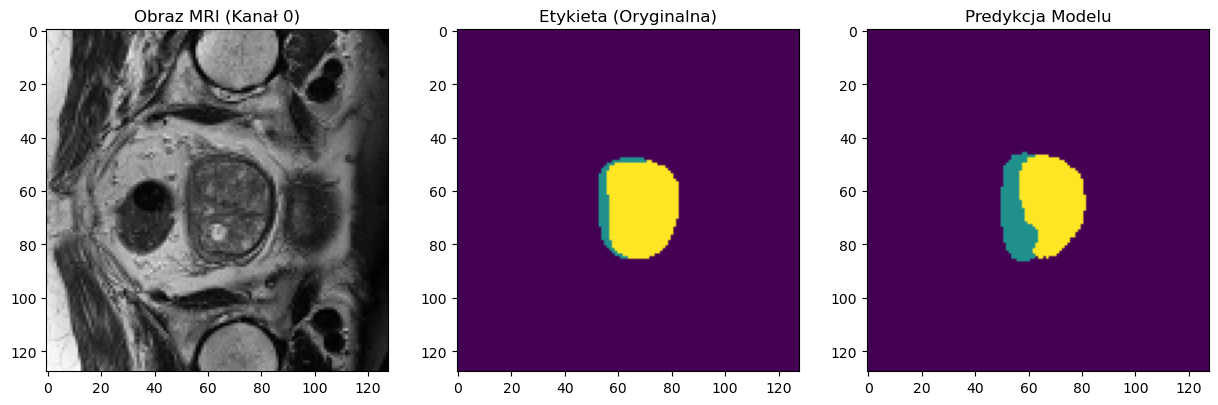

In [4]:
# checkpoint_path = "../checkpoints/best-attention-vnet-epoch=31-val_dice=0.616.ckpt"
# checkpoint_path = "../checkpoints/best-attention-vnet-epoch=34-val_dice=0.609.ckpt"
# checkpoint_path = "../checkpoints/run_2/best-attention-vnet-epoch=25-val_dice=0.642.ckpt"
# checkpoint_path = "../checkpoints/run_4/best-attention-vnet-epoch=97-val_dice=0.351.ckpt"
# checkpoint_path = "../checkpoints/run_5/best-attention-vnet-epoch=08-val_dice=0.417.ckpt"
# checkpoint_path = "../checkpoints/best-attention-vnet-epoch=387-val_dice=0.326.ckpt"
# checkpoint_path = "../checkpoints/best-attention-vnet-epoch=03-val_dice=0.273.ckpt"
# checkpoint_path = "../checkpoints/best-attention-vnet-epoch=174-val_dice=0.411.ckpt"
# checkpoint_path = "../checkpoints/best-attention-vnet-epoch=42-val_dice=0.416.ckpt"
# checkpoint_path = "../checkpoints/run_11/best-attention-vnet-epoch=79-val_dice=0.564.ckpt"
# checkpoint_path = "../checkpoints/run_12/best-attention-vnet-epoch=53-val_dice=0.560.ckpt"
# checkpoint_path = "../checkpoints/run_13/best-attention-vnet-epoch=114-val_dice=0.553.ckpt"
# checkpoint_path = "../checkpoints/run_15/best-attention-vnet-epoch=96-val_dice=0.553.ckpt"
checkpoint_path = "../checkpoints/run_17/best-attention-vnet-epoch=194-val_dice=0.567.ckpt"

model = LitBaseVNet.load_from_checkpoint(
    checkpoint_path, 
    model_obj=AttentionVNet(in_ch=2, out_ch=3, base_channels=24)
)
model.eval()
model.cuda()

# dm.setup(stage="fit")
# batch = next(iter(dm.val_dataloader()))

dm.setup(stage="train") 
train_loader = dm.train_dataloader()
batch = next(iter(train_loader))


# dm.setup(stage="test") 
# test_loader = dm.test_dataloader()
# batch = next(iter(test_loader))

x, y = model._prepare_batch(batch)
x = x.cuda()

with torch.no_grad():
    logits = model(x)
    preds = torch.argmax(logits, dim=1)

slice_idx = 32 # Przekrój w połowie głębokości (roi_size to 64)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Obraz MRI (Kanał 0)")
plt.imshow(x[0, 0, :, :, slice_idx].cpu(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Etykieta (Oryginalna)")
plt.imshow(y[0, 0, :, :, slice_idx].cpu())

plt.subplot(1, 3, 3)
plt.title("Predykcja Modelu")
plt.imshow(preds[0, :, :, slice_idx].cpu())

plt.show()




Loading dataset: 100%|██████████| 16/16 [00:01<00:00, 13.40it/s]


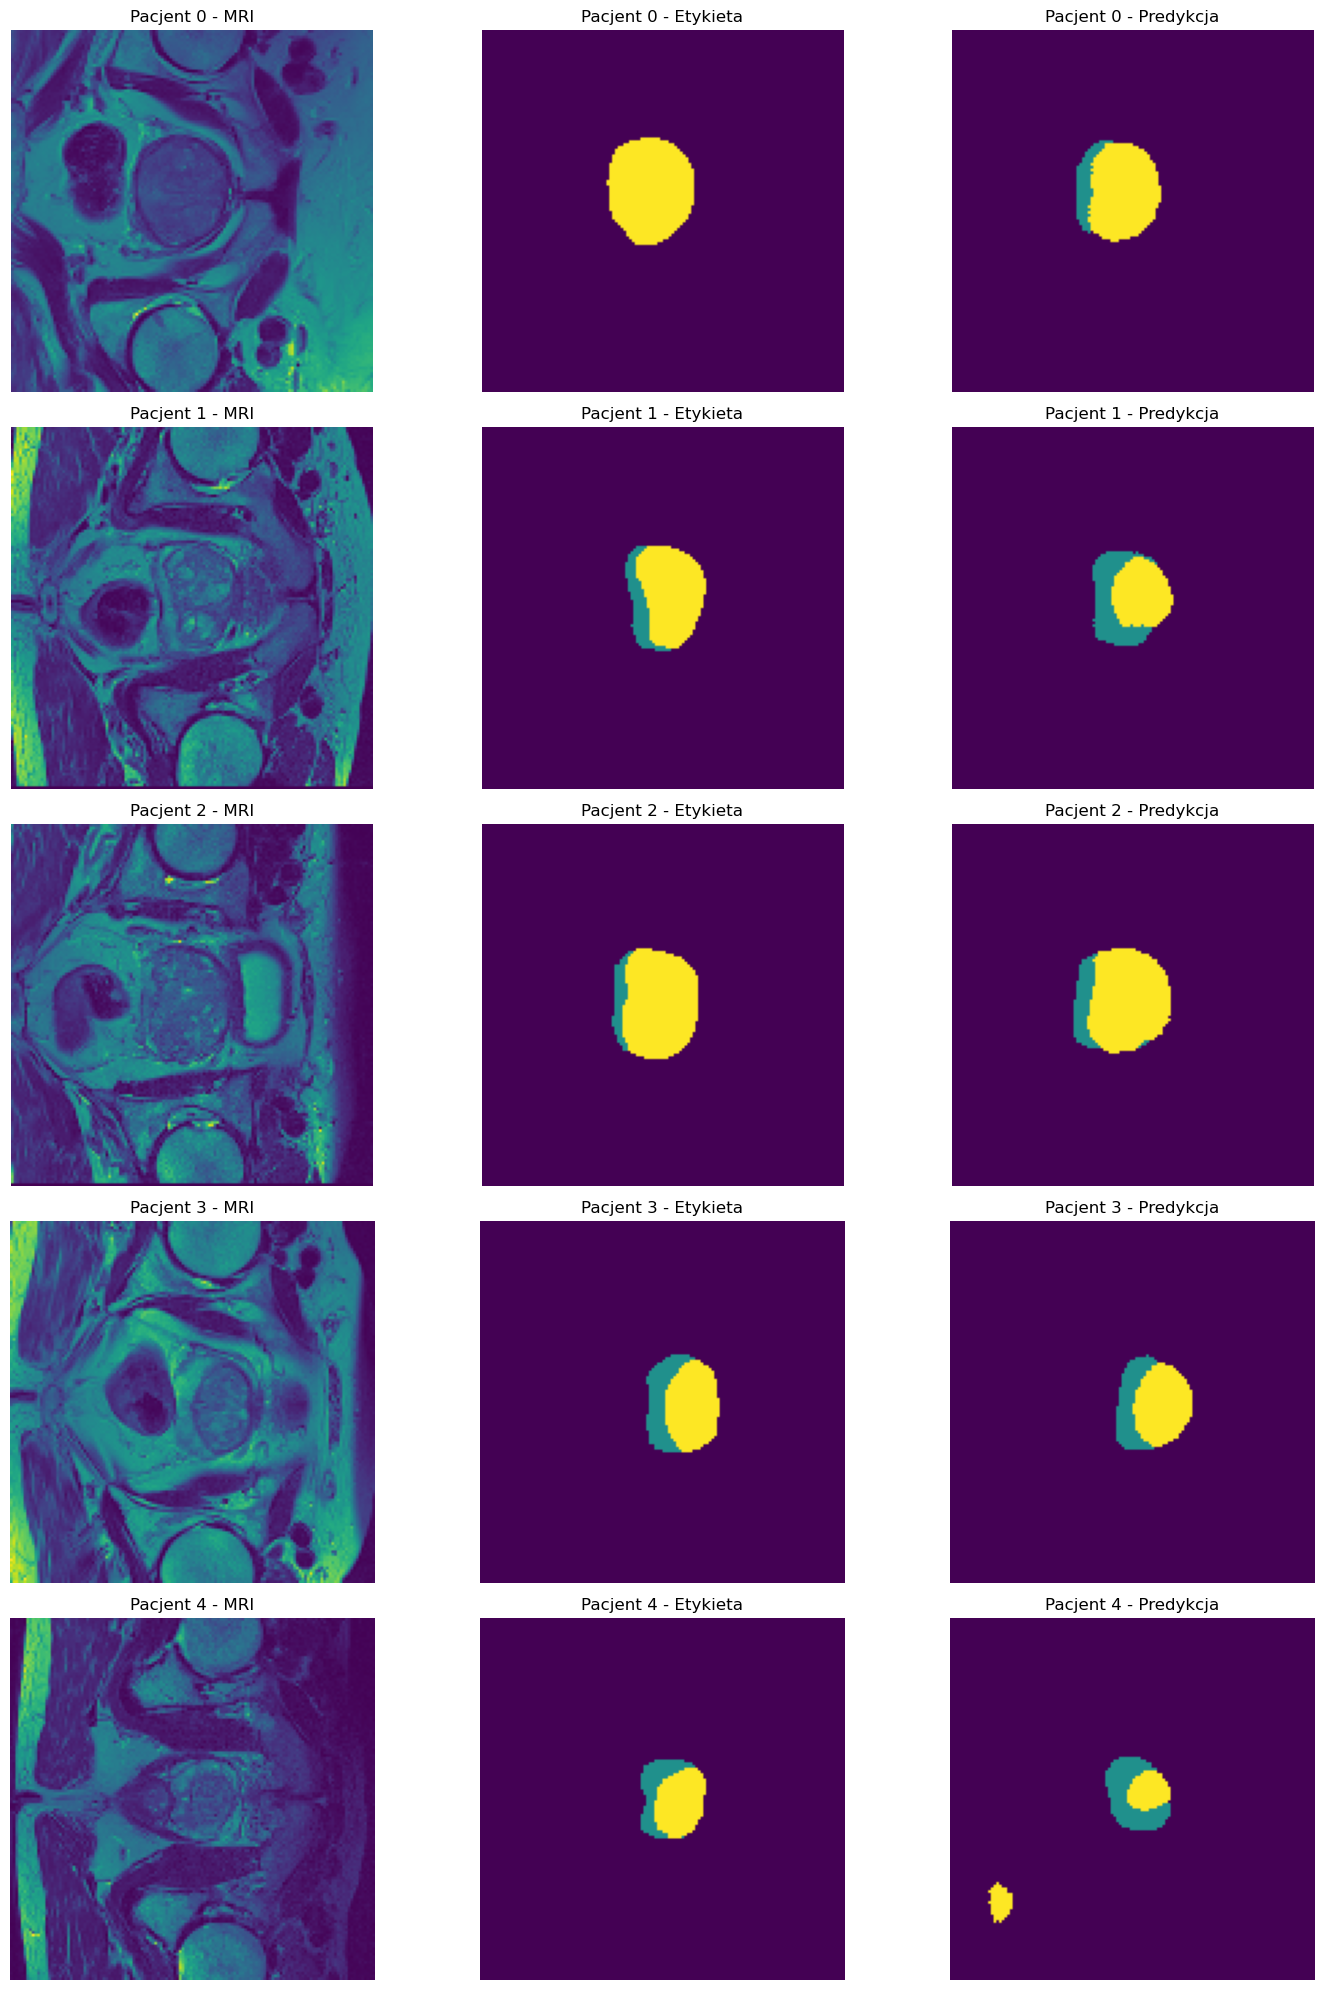

In [10]:
model.eval()
model.cuda()

dm.setup(stage="fit")
val_loader = dm.val_dataloader()
val_iter = iter(val_loader)

num_to_show = 5
results = []

while len(results) < num_to_show:
    try:
        batch = next(val_iter)
        x_batch, y_batch = model._prepare_batch(batch)
        x_batch = x_batch.cuda()
        
        with torch.no_grad():
            logits = model(x_batch)
            preds_batch = torch.argmax(logits, dim=1)
        
        for i in range(x_batch.shape[0]):
            if len(results) < num_to_show:
                results.append({
                    'img': x_batch[i, 0, :, :, 32].cpu().numpy(),
                    'mask': y_batch[i, 0, :, :, 32].cpu().numpy(),
                    'pred': preds_batch[i, :, :, 32].cpu().numpy()
                })
            else:
                break
    except StopIteration:
        break

fig, axes = plt.subplots(len(results), 3, figsize=(15, 4 * len(results)))

for i, res in enumerate(results):
    # MRI
    axes[i, 0].imshow(res['img'])
    axes[i, 0].set_title(f"Pacjent {i} - MRI")
    axes[i, 0].axis("off")

    # Etykieta
    axes[i, 1].imshow(res['mask'])
    axes[i, 1].set_title(f"Pacjent {i} - Etykieta")
    axes[i, 1].axis("off")

    # Predykcja
    axes[i, 2].imshow(res['pred'])
    axes[i, 2].set_title(f"Pacjent {i} - Predykcja")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# To run tensorboard graphs, enter in the console:
tensorboard --logdir tb_logs  


In [6]:
plain_vnet = VNet(in_ch=2, out_ch=3, base_channels=24)
model_vnet = LitBaseVNet(model_obj=plain_vnet, in_ch=2, out_ch=3, lr=1e-4)

In [ ]:
checkpoint_callback_vnet = ModelCheckpoint(
    monitor="val_dice",
    dirpath="../checkpoints_vnet/",
    filename="best-vnet-{epoch:02d}-{val_dice:.3f}",
    save_top_k=1,
    mode="max",
)

checkpoint_callback_last_vnet = ModelCheckpoint(
    dirpath="../checkpoints_vnet/",
    filename="last-model",
    save_top_k=1,
    every_n_epochs=1,
    save_on_train_epoch_end=True
)

early_stop_callback_vnet = EarlyStopping(
    monitor="val_dice",
    patience=250,
    mode="max",
    verbose=True
)

lr_monitor_vnet = LearningRateMonitor(logging_interval='epoch')

vnet_logger = TensorBoardLogger(
    save_dir="../tb_logs", 
    name="vnet"
)

trainer_vnet  = pl.Trainer(
    max_epochs=600,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback_vnet , early_stop_callback_vnet , checkpoint_callback_last_vnet , lr_monitor_vnet ],
    logger=vnet_logger,
    log_every_n_steps=10,
    accumulate_grad_batches=4
)

trainer_vnet .fit(model_vnet , datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 27.78it/s]
Checkpoint directory /home/tim/medyczne/projekt/Prostate-MRI-Segmentation/checkpoints_vnet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | VNet                   | 6.6 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
--------

Epoch 0: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s, v_num=2, val_loss=2.950, val_dice=0.0363, train_loss=2.910]

Metric val_dice improved. New best score: 0.036


Epoch 1: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=2, val_loss=2.890, val_dice=0.073, train_loss=2.830] 

Metric val_dice improved by 0.037 >= min_delta = 0.0. New best score: 0.073


Epoch 2: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=2, val_loss=2.850, val_dice=0.112, train_loss=2.780]

Metric val_dice improved by 0.039 >= min_delta = 0.0. New best score: 0.112


Epoch 9: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s, v_num=2, val_loss=2.690, val_dice=0.131, train_loss=2.630] 

Metric val_dice improved by 0.018 >= min_delta = 0.0. New best score: 0.131


Epoch 11: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s, v_num=2, val_loss=2.660, val_dice=0.218, train_loss=2.590]

Metric val_dice improved by 0.087 >= min_delta = 0.0. New best score: 0.218


Epoch 13: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=2, val_loss=2.610, val_dice=0.272, train_loss=2.560]

Metric val_dice improved by 0.054 >= min_delta = 0.0. New best score: 0.272


Epoch 22: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=2, val_loss=2.530, val_dice=0.287, train_loss=2.450]

Metric val_dice improved by 0.015 >= min_delta = 0.0. New best score: 0.287


Epoch 26: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=2, val_loss=2.500, val_dice=0.313, train_loss=2.410]

Metric val_dice improved by 0.027 >= min_delta = 0.0. New best score: 0.313


Epoch 30: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=2, val_loss=2.490, val_dice=0.315, train_loss=2.380]

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.315


Epoch 35: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s, v_num=2, val_loss=2.500, val_dice=0.341, train_loss=2.360]

Metric val_dice improved by 0.025 >= min_delta = 0.0. New best score: 0.341


Epoch 50: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s, v_num=2, val_loss=2.420, val_dice=0.366, train_loss=2.330]

Metric val_dice improved by 0.025 >= min_delta = 0.0. New best score: 0.366


Epoch 69: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s, v_num=2, val_loss=2.100, val_dice=0.398, train_loss=2.020]

Metric val_dice improved by 0.032 >= min_delta = 0.0. New best score: 0.398


Epoch 75: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s, v_num=2, val_loss=2.090, val_dice=0.431, train_loss=1.960] 

Metric val_dice improved by 0.033 >= min_delta = 0.0. New best score: 0.431


Epoch 82: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=2, val_loss=1.940, val_dice=0.453, train_loss=1.770]

Metric val_dice improved by 0.022 >= min_delta = 0.0. New best score: 0.453


Epoch 90: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s, v_num=2, val_loss=1.830, val_dice=0.468, train_loss=1.650]

Metric val_dice improved by 0.016 >= min_delta = 0.0. New best score: 0.468


Epoch 96: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s, v_num=2, val_loss=1.780, val_dice=0.481, train_loss=1.580]

Metric val_dice improved by 0.013 >= min_delta = 0.0. New best score: 0.481


Epoch 99: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s, v_num=2, val_loss=1.780, val_dice=0.491, train_loss=1.520]

Metric val_dice improved by 0.010 >= min_delta = 0.0. New best score: 0.491


Epoch 103: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s, v_num=2, val_loss=1.650, val_dice=0.491, train_loss=1.440]

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.491


Epoch 105: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s, v_num=2, val_loss=1.710, val_dice=0.508, train_loss=1.430]

Metric val_dice improved by 0.017 >= min_delta = 0.0. New best score: 0.508


Epoch 111: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s, v_num=2, val_loss=1.620, val_dice=0.514, train_loss=1.340]

Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.514


Epoch 120: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s, v_num=2, val_loss=1.560, val_dice=0.518, train_loss=1.240]

Metric val_dice improved by 0.004 >= min_delta = 0.0. New best score: 0.518


Epoch 130: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s, v_num=2, val_loss=1.540, val_dice=0.519, train_loss=1.180]

Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.519


Epoch 136: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s, v_num=2, val_loss=1.540, val_dice=0.521, train_loss=1.150]

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.521


Epoch 140: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s, v_num=2, val_loss=1.520, val_dice=0.525, train_loss=1.180]

Metric val_dice improved by 0.004 >= min_delta = 0.0. New best score: 0.525


Epoch 141: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s, v_num=2, val_loss=1.520, val_dice=0.525, train_loss=1.170]

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.525


Epoch 142: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s, v_num=2, val_loss=1.510, val_dice=0.530, train_loss=1.150]

Metric val_dice improved by 0.005 >= min_delta = 0.0. New best score: 0.530


Epoch 173: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s, v_num=2, val_loss=1.350, val_dice=0.535, train_loss=1.030] 

Metric val_dice improved by 0.005 >= min_delta = 0.0. New best score: 0.535


Epoch 182: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s, v_num=2, val_loss=1.220, val_dice=0.570, train_loss=0.948]

Metric val_dice improved by 0.035 >= min_delta = 0.0. New best score: 0.570


Epoch 194: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s, v_num=2, val_loss=1.190, val_dice=0.580, train_loss=0.887]

Metric val_dice improved by 0.009 >= min_delta = 0.0. New best score: 0.580


Epoch 444: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s, v_num=2, val_loss=1.280, val_dice=0.538, train_loss=0.421]

Monitored metric val_dice did not improve in the last 250 records. Best score: 0.580. Signaling Trainer to stop.


Epoch 444: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, v_num=2, val_loss=1.280, val_dice=0.538, train_loss=0.421]


Loading dataset: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]


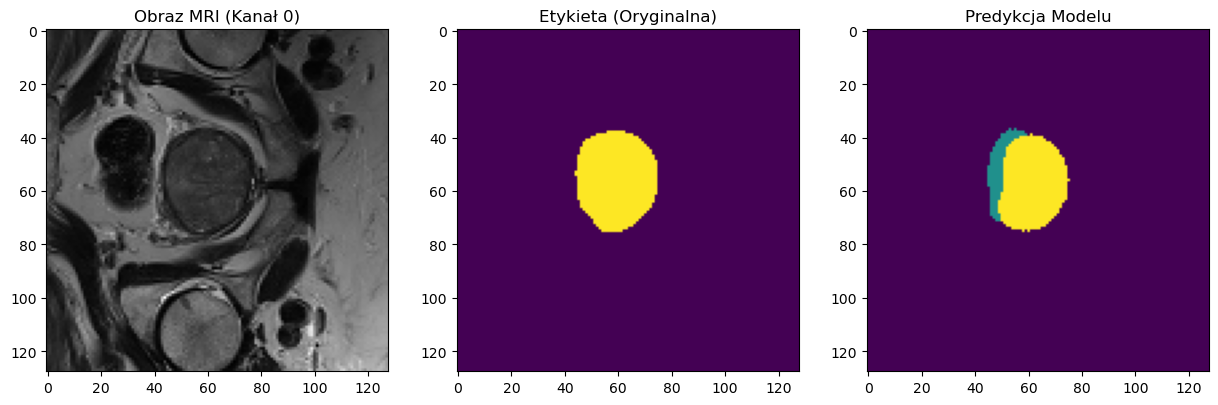

In [7]:
# checkpoint_vnet_path = "../checkpoints_vnet/run_0/best-vnet-epoch=21-val_dice=0.569.ckpt"
# checkpoint_vnet_path = "../checkpoints_vnet/run_1/best-vnet-epoch=65-val_dice=0.376.ckpt"
checkpoint_vnet_path = "../checkpoints_vnet/run_2/best-vnet-epoch=194-val_dice=0.580.ckpt"

model_vnet = LitBaseVNet.load_from_checkpoint(
    checkpoint_vnet_path, 
    model_obj=plain_vnet
)
model_vnet.eval()
model_vnet.cuda()

dm.setup(stage="fit")
batch = next(iter(dm.val_dataloader()))

x, y = model_vnet._prepare_batch(batch)
x = x.cuda()

with torch.no_grad():
    logits = model_vnet(x)
    preds = torch.argmax(logits, dim=1)

slice_idx = 32 # Przekrój w połowie głębokości (roi_size to 64)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Obraz MRI (Kanał 0)")
plt.imshow(x[0, 0, :, :, slice_idx].cpu(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Etykieta (Oryginalna)")
plt.imshow(y[0, 0, :, :, slice_idx].cpu())

plt.subplot(1, 3, 3)
plt.title("Predykcja Modelu")
plt.imshow(preds[0, :, :, slice_idx].cpu())

plt.show()

Loading dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 16/16 [00:01<00:00, 12.15it/s]


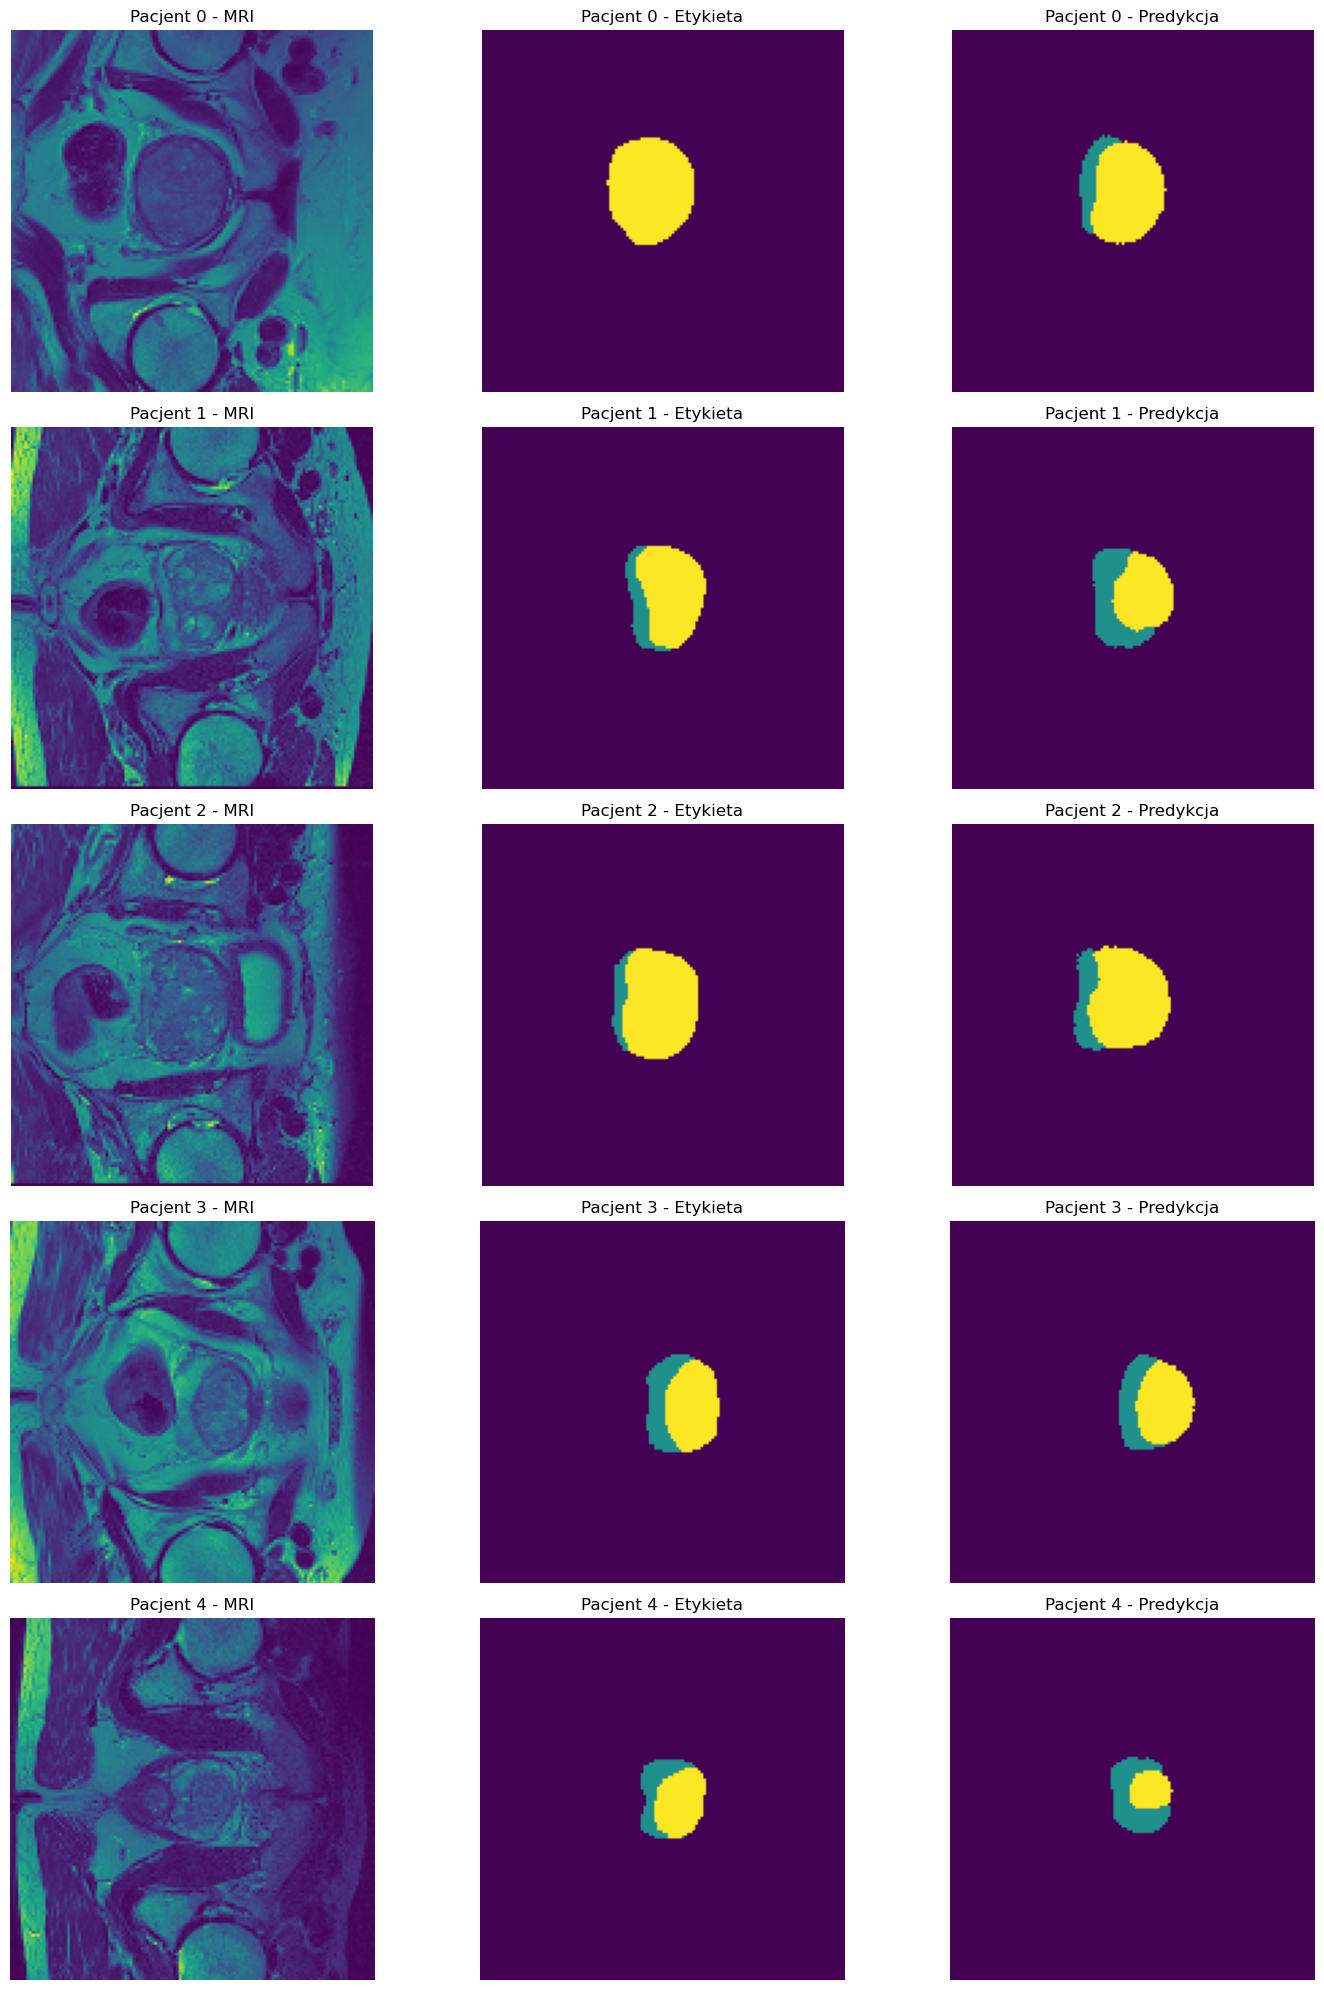

In [9]:
model_vnet.eval()
model_vnet.cuda()

dm.setup(stage="fit")
val_loader = dm.val_dataloader()
val_iter = iter(val_loader)

num_to_show = 5
results = []

while len(results) < num_to_show:
    try:
        batch = next(val_iter)
        x_batch, y_batch = model_vnet._prepare_batch(batch)
        x_batch = x_batch.cuda()
        
        with torch.no_grad():
            logits = model_vnet(x_batch)
            preds_batch = torch.argmax(logits, dim=1)
        
        for i in range(x_batch.shape[0]):
            if len(results) < num_to_show:
                results.append({
                    'img': x_batch[i, 0, :, :, 32].cpu().numpy(),
                    'mask': y_batch[i, 0, :, :, 32].cpu().numpy(),
                    'pred': preds_batch[i, :, :, 32].cpu().numpy()
                })
            else:
                break
    except StopIteration:
        break

fig, axes = plt.subplots(len(results), 3, figsize=(15, 4 * len(results)))

for i, res in enumerate(results):
    # MRI
    axes[i, 0].imshow(res['img'])
    axes[i, 0].set_title(f"Pacjent {i} - MRI")
    axes[i, 0].axis("off")

    # Etykieta
    axes[i, 1].imshow(res['mask'])
    axes[i, 1].set_title(f"Pacjent {i} - Etykieta")
    axes[i, 1].axis("off")

    # Predykcja
    axes[i, 2].imshow(res['pred'])
    axes[i, 2].set_title(f"Pacjent {i} - Predykcja")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()